## THIS IS WHERE YOU START
## Build your  Model (LSTM, CNN, Neural Network, XGBOOST, RF..etc)



In [6]:
import numpy as np

X_train = np.load('Dataset/Dataset/Npy_files/x_train.npy')
X_test = np.load('Dataset/Dataset/Npy_files/x_test.npy')

y_train = np.load('Dataset/Dataset/Npy_files/binary_y_train.npy')
y_test = np.load('Dataset/Dataset/Npy_files/binary_y_test.npy')

In [7]:
# alternative
# import numpy as np
# X_train = np.load("x_train.npy")
# X_test = np.load("x_test.npy")
# y_train = np.load("binary_y_train.npy")
# y_test = np.load("binary_y_test.npy")

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [9]:
# data
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

optimizer: tried SGD but loss would stay at 0.693

In [10]:
# model training
def train_model(model, learning_rate, num_epochs, batch_size):
  loss_function = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_loader = DataLoader(train_data, batch_size=batch_size)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  model.train()

  for epoch in range(num_epochs):
    running_loss = 0.0

    for X, y in train_loader:
      X = X.to(device)
      y = y.to(device)

      output = model(X)

      loss = loss_function(output, y)
      running_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # print out loss every 10 epochs
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

In [11]:
# model validation
# returns and prints out accuracy
def eval_model(model):
  model.eval()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  test_loader = DataLoader(test_data, batch_size=batch_size)

  correct = 0
  total = 0
  for X, y in test_loader:
    X = X.to(device)
    y = y.to(device)
    outputs = model(X)
    probs = torch.sigmoid(outputs)
    preds = probs > 0.5
    correct += (preds == y).sum().item()
    total += y.size(0)

  accuracy = correct/total * 100
  print("Accuracy:", accuracy)

to do: hyperparam tuning, cross-validation, improving model architecture, other models

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [21]:
def plot_roc(model):

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_loader = DataLoader(test_data, batch_size=batch_size)

    y_pred_proba = []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)

            outputs = model(X)
            probs = torch.sigmoid(outputs)

            y_pred_proba.extend(probs.cpu().numpy())
            

#     print(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Chance')
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

###LSTM

In [14]:
class LSTMModel(nn.Module):
  def __init__(self, hidden_size, num_layers):
    super(LSTMModel, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(500, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
    out, (hn, cn) = self.lstm(x, (h_0, c_0))
    out = self.fc(out[:, -1, :])
    return out

In [15]:
# hyperparameters
hidden_size = 64
num_layers = 3
learning_rate = 0.005
num_epochs = 100
batch_size = 64

In [16]:
LSTM = LSTMModel(hidden_size, num_layers)
train_model(LSTM, learning_rate, num_epochs, batch_size)

Epoch: 0, loss: 0.59253
Epoch: 10, loss: 0.31099
Epoch: 20, loss: 0.20026
Epoch: 30, loss: 0.15106
Epoch: 40, loss: 0.00962
Epoch: 50, loss: 0.08731
Epoch: 60, loss: 0.00161
Epoch: 70, loss: 0.00071
Epoch: 80, loss: 0.00161
Epoch: 90, loss: 0.00218


In [17]:
eval_model(LSTM)

Accuracy: 89.98716302952504


AUC: 0.95


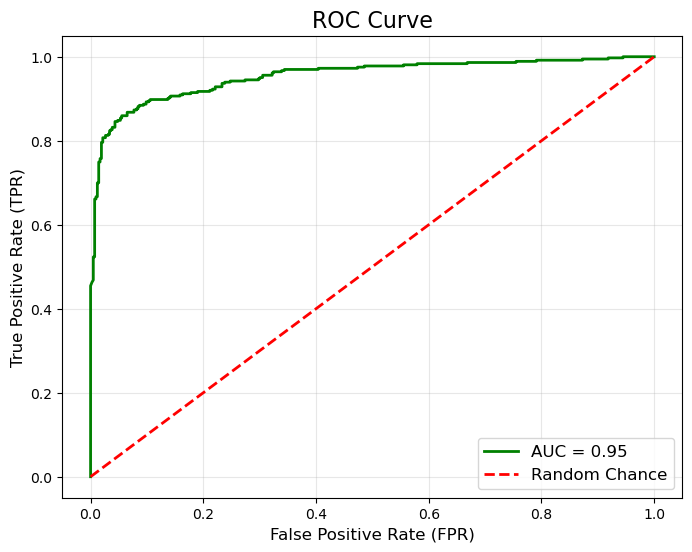

In [22]:
plot_roc(LSTM)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, recall_score, f1_score
#confusion matrix code
def evaluate_model(model, test_data, batch_size):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            
            outputs = model(X)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()  # 0.5 for threshold
            
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0(Normal)', 'Class 1(Seizure)'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Metrics for recall , f1 score
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    # report
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print("\nClassification Report:\n")
    print(report)


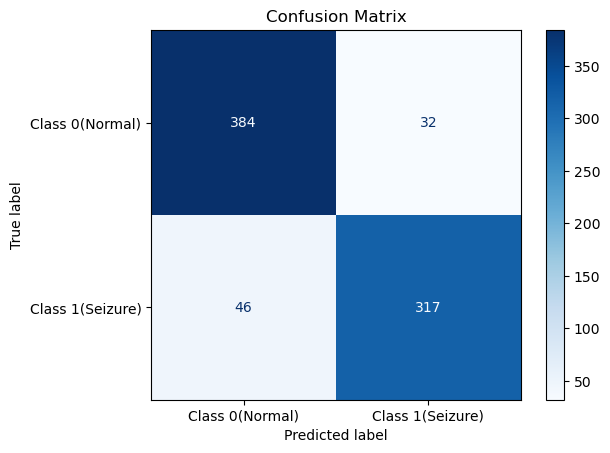

Recall: 0.87
F1 Score: 0.89

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.89      0.92      0.91       416
     Class 1       0.91      0.87      0.89       363

    accuracy                           0.90       779
   macro avg       0.90      0.90      0.90       779
weighted avg       0.90      0.90      0.90       779



In [26]:
evaluate_model(LSTM, test_data, batch_size) #heatmap

### CNN

In [28]:
# data for CNN
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

In [29]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(23616, 128)
    self.fc2 = nn.Linear(128, 1)

  def forward(self, x):
    x = self.pool1(self.relu(self.conv1(x)))
    x = self.pool2(self.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [30]:
# hyperparameters
learning_rate = 0.001
num_epochs = 100
batch_size = 32

In [66]:
CNN = CNNModel()
train_model(CNN, learning_rate, num_epochs, batch_size)

Epoch: 0, loss: 0.21128
Epoch: 10, loss: 0.09577
Epoch: 20, loss: 0.03051
Epoch: 30, loss: 0.00327
Epoch: 40, loss: 0.00525
Epoch: 50, loss: 0.00082
Epoch: 60, loss: 0.00077
Epoch: 70, loss: 0.00013
Epoch: 80, loss: 0.00001
Epoch: 90, loss: 0.00000


In [67]:
eval_model(CNN)

Accuracy: 90.11553273427471


AUC: 0.96


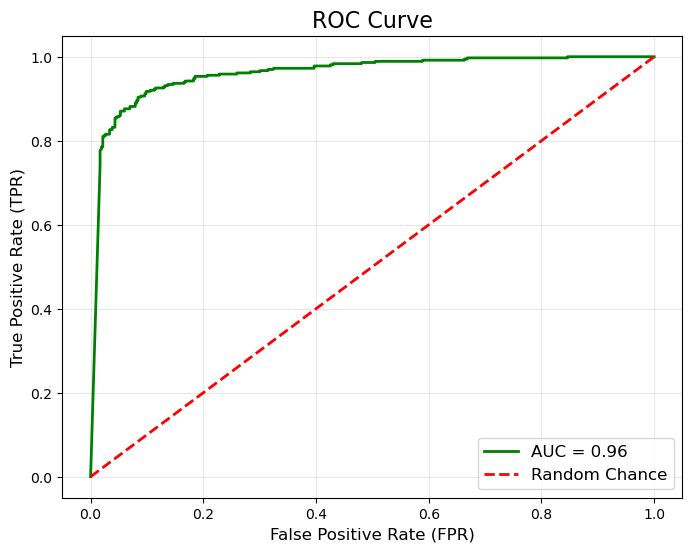

In [33]:
plot_roc(CNN)

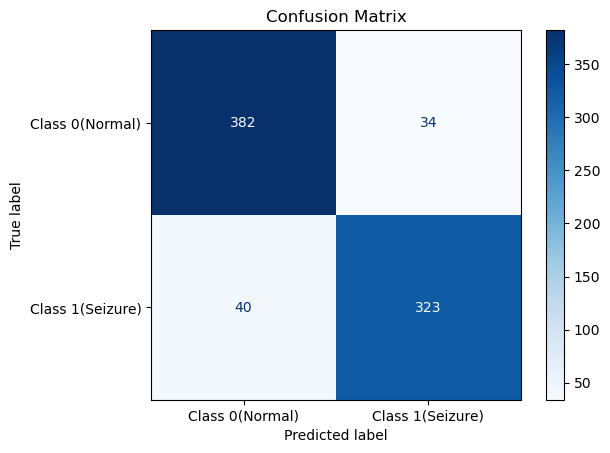

Recall: 0.89
F1 Score: 0.90

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.91      0.92      0.91       416
     Class 1       0.90      0.89      0.90       363

    accuracy                           0.91       779
   macro avg       0.90      0.90      0.90       779
weighted avg       0.91      0.91      0.90       779



In [34]:
evaluate_model(CNN, test_data, batch_size) #heatmap

### XGBoost

In [35]:
!pip install optuna

In [36]:
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [37]:
X_train_xgboost = X_train.reshape(X_train.shape[0], -1)
X_test_xgboost = X_test.reshape(X_test.shape[0], -1)

In [38]:
X_train_xgboost.shape

(7011, 9500)

should reduce number of features for this, maybe like pca

In [39]:
# center mean and scale data before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_xgboost)
X_test_scaled = scaler.transform(X_test_xgboost)

In [40]:
# PCA
pca = PCA(n_components=100)
X_train_decomp = pca.fit_transform(X_train_scaled)
X_test_decomp = pca.transform(X_test_scaled)

In [41]:
X_train_decomp.shape

(7011, 100)

In [42]:
# hyperparameter tuning
def objective_xgb(trial):
  params = {
  'objective': 'binary:logistic',
  'max_depth': trial.suggest_int('max_depth', 5, 25),
  'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
  'subsample': trial.suggest_float('subsample', 0.01, 1),
  'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1),
  'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
  'n_estimators': trial.suggest_int('n_estimators', 300, 700),
  'random_state': 2
  }
  model = XGBClassifier(**params, verbosity=0, device='cuda', n_jobs=-1)
  scores = cross_val_score(model, X_train_decomp, y_train, cv=5, scoring='neg_log_loss')
  return -scores.mean()

In [43]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb, n_trials=100)

[I 2024-12-10 10:46:49,149] A new study created in memory with name: no-name-56ce2ebd-0592-42b8-b2bc-2ade6c4a2375
[I 2024-12-10 10:47:01,094] Trial 0 finished with value: 0.3054433870196198 and parameters: {'max_depth': 18, 'min_child_weight': 13, 'subsample': 0.6350848158006096, 'colsample_bytree': 0.11420985863177248, 'learning_rate': 0.08887367831148091, 'n_estimators': 434}. Best is trial 0 with value: 0.3054433870196198.
[I 2024-12-10 10:47:20,485] Trial 1 finished with value: 0.2974664799647396 and parameters: {'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.35203007630039357, 'colsample_bytree': 0.4313141445561359, 'learning_rate': 0.07999045320903046, 'n_estimators': 650}. Best is trial 1 with value: 0.2974664799647396.
[I 2024-12-10 10:47:40,830] Trial 2 finished with value: 0.28014175412963926 and parameters: {'max_depth': 25, 'min_child_weight': 11, 'subsample': 0.9917631893191943, 'colsample_bytree': 0.3320193191931476, 'learning_rate': 0.05205107112599036, 'n_estima

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params
print("Best params:", best_params)

Best params: {'max_depth': 16, 'min_child_weight': 5, 'subsample': 0.7448212443157052, 'colsample_bytree': 0.6826161695481427, 'learning_rate': 0.04414459073458647, 'n_estimators': 503}


In [44]:
best_params= {'max_depth': 16, 'min_child_weight': 5, 'subsample': 0.7448212443157052, 'colsample_bytree': 0.6826161695481427, 'learning_rate': 0.04414459073458647, 'n_estimators': 503}

In [45]:
XGB = XGBClassifier(**best_params, device='cuda', objective='binary:logistic', eval_metric='auc')
XGB.fit(X_train_decomp, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6826161695481427, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04414459073458647,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=503, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [48]:
y_pred = XGB.predict(X_test_decomp)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9024390243902439


In [49]:
def plot_roc_xgb(model):

    y_pred_proba = XGB.predict_proba(X_test_decomp)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random Chance')
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('ROC Curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

AUC: 0.96


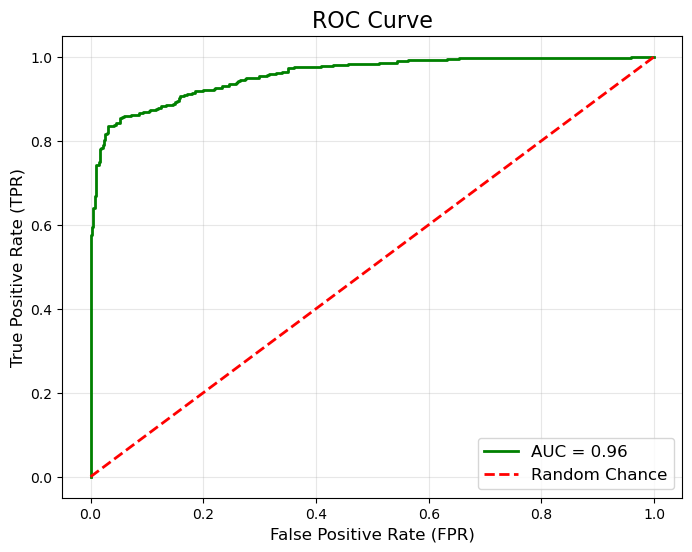

In [64]:
plot_roc_xgb(XGB)

In [61]:
X_train_xgboost

array([[-2.98175984e-05, -1.51887996e-04, -6.03351979e-05, ...,
         1.76703901e-02,  1.87995413e-02,  1.94404109e-02],
       [-1.95242637e-03, -2.07449676e-03, -1.98294397e-03, ...,
        -9.85648463e-03, -1.02226958e-02, -1.06499422e-02],
       [-1.52517997e-03, -1.58621517e-03, -1.46414477e-03, ...,
        -1.09793358e-03, -8.84310384e-04, -8.23275185e-04],
       ...,
       [-1.76932077e-03, -1.55569757e-03, -1.73880317e-03, ...,
        -2.74588395e-03, -2.37967276e-03, -2.07449676e-03],
       [-1.76384725e-02, -1.96831517e-02, -2.16057604e-02, ...,
         4.24264633e-03,  4.54782232e-03,  4.88351592e-03],
       [ 6.17352000e-05, -2.98175984e-05, -1.21370397e-04, ...,
        -3.96658793e-03, -4.82108072e-03, -5.70609110e-03]])

In [56]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, recall_score, f1_score

def evaluate_model_sklearn(model, test_data, batch_size):
    # Test 데이터 준비
    X_test = test_data[:][0] # feature
    y_test = test_data[:][1]  # label

    # 모델 예측
    y_pred = model.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Metrics
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    # Classification Report
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    print("\nClassification Report:\n")
    print(report)

# 예시: Scikit-learn XGBoost 모델과 test_data를 활용하여 평가
evaluate_model_sklearn(XGB, X_test_xgboost, batch_size)


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

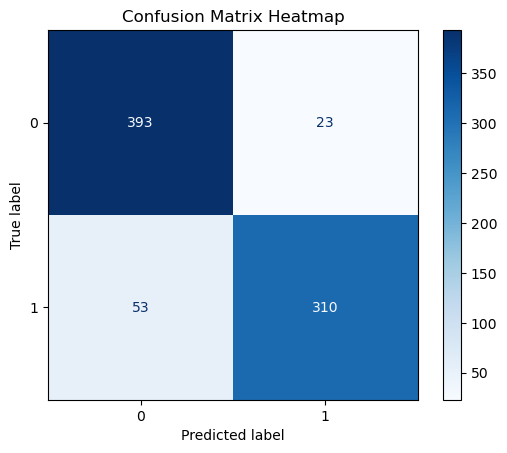


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.88      0.94      0.91       416
     Class 1       0.93      0.85      0.89       363

    accuracy                           0.90       779
   macro avg       0.91      0.90      0.90       779
weighted avg       0.90      0.90      0.90       779



In [63]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = XGB.predict(X_test_decomp)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)]))
